In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils.class_weight import compute_class_weight
import joblib
from sklearn.metrics import classification_report, multilabel_confusion_matrix

In [3]:
emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy',
            'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

#load data
try:
    df = pd.read_csv(
        '/content/drive/Shared drives/CSI 5130/SemEval2018-Task1-all-data/English/E-c/train.txt',
        sep='\t',
        header=0,
        dtype={'ID': str, 'Tweet': str, **{e: int for e in emotions}}
    )
    print("Data loaded successfully. Shape:", df.shape)
except Exception as e:
    print("Error loading data:", e)
    raise

print("\nInitial label counts:")
print(df[emotions].sum())

Data loaded successfully. Shape: (6838, 13)

Initial label counts:
anger           2544
anticipation     978
disgust         2602
fear            1242
joy             2477
love             700
optimism        1984
pessimism        795
sadness         2008
surprise         361
trust            357
dtype: int64


In [4]:
import re

def clean_tweet(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'#(\w+)', r'\1', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

df['clean_tweet'] = df['Tweet'].apply(clean_tweet)

# verify labels before splitting
print("\nLabel verification before splitting:")
print("Data types:", df[emotions].dtypes)
print("Label counts:")
print(df[emotions].sum())

# handle non-numeric values in emotion columns
for emotion in emotions:
    if df[emotion].dtype == object:
        print(f"\nConverting {emotion} column...")
        # convert to numeric
        df[emotion] = pd.to_numeric(df[emotion], errors='coerce').fillna(0).astype(int)

# final verification
print("\nFinal label counts:")
print(df[emotions].sum())
print("\nSample labels:")
print(df[emotions].head())

from sklearn.model_selection import train_test_split

# split data
X_train, X_test, Y_train, Y_test = train_test_split(
    df['clean_tweet'],
    df[emotions],
    test_size=0.2,
    random_state=42,
    stratify=df[emotions].values.argmax(axis=1)  # preserve class balance
)

# convert to numpy arrays
Y_train_values = Y_train.astype('float32').values
Y_test_values = Y_test.astype('float32').values

# verify splits
print("\nTraining label distribution:")
print(Y_train.sum())
print("\nTest label distribution:")
print(Y_test.sum())


Label verification before splitting:
Data types: anger           int64
anticipation    int64
disgust         int64
fear            int64
joy             int64
love            int64
optimism        int64
pessimism       int64
sadness         int64
surprise        int64
trust           int64
dtype: object
Label counts:
anger           2544
anticipation     978
disgust         2602
fear            1242
joy             2477
love             700
optimism        1984
pessimism        795
sadness         2008
surprise         361
trust            357
dtype: int64

Final label counts:
anger           2544
anticipation     978
disgust         2602
fear            1242
joy             2477
love             700
optimism        1984
pessimism        795
sadness         2008
surprise         361
trust            357
dtype: int64

Sample labels:
   anger  anticipation  disgust  fear  joy  love  optimism  pessimism  \
0      0             1        0     0    0     0         1          0   
1      0 

In [5]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import classification_report
from scipy.sparse import hstack, csr_matrix
from sklearn.calibration import CalibratedClassifierCV
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix
from sklearn.model_selection import train_test_split

# vectorization
tfidf_vec = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 3),
    stop_words='english',
    min_df=5,
    max_df=0.4,
    sublinear_tf=True
)
X_train_tfidf = tfidf_vec.fit_transform(X_train)
X_test_tfidf = tfidf_vec.transform(X_test)

# store original text for fallback analysis
X_test_texts = X_test.values

# lexicon features for weak emotions
weak_emotions = ['pessimism', 'surprise', 'trust', 'anticipation']
emotion_lexicons = {
    'pessimism': ['hopeless', 'doom', 'bleak', 'futile', 'disaster', 'collapse'],
    'surprise': ['astounding', 'incredible', 'remarkable', 'unexpected', 'shocking'],
    'trust': ['reliable', 'dependable', 'trustworthy', 'credible', 'authentic'],
    'anticipation': ['awaiting', 'expecting', 'upcoming', 'foresee', 'imminent']
}

# lexicon vectorizers
lexicon_vecs = {}
for emotion in weak_emotions:
    vec = CountVectorizer(vocabulary=emotion_lexicons[emotion], binary=True)
    lexicon_vecs[emotion] = vec
    # fit transform on training, only transform on test
    lex_train = vec.fit_transform(X_train)
    X_train_tfidf = hstack([X_train_tfidf, lex_train])
    lex_test = vec.transform(X_test)
    X_test_tfidf = hstack([X_test_tfidf, lex_test])

# model training
emotion_models = {}
final_thresholds = {
    'anger': 0.50,
    'anticipation': 0.45,
    'disgust': 0.48,
    'fear': 0.60,
    'joy': 0.50,
    'love': 0.55,
    'optimism': 0.50,
    'pessimism': 0.55,
    'sadness': 0.50,
    'surprise': 0.65,
    'trust': 0.65
}

for emotion in emotions:
    if emotion in weak_emotions:
        base_model = ComplementNB(alpha=0.1, norm=True)
        model = CalibratedClassifierCV(base_model, method='sigmoid', cv=3)
    else:
        model = MultinomialNB(alpha=0.05)

    model.fit(X_train_tfidf, Y_train[emotion])
    emotion_models[emotion] = model

# prediction with text fallback
def predict_with_fallback(X_vec, X_text, emotion):
    # model prediction
    proba = emotion_models[emotion].predict_proba(X_vec)[:,1]
    preds = (proba >= final_thresholds[emotion]).astype(int)

    # lexicon boost for weak predictions
    if emotion in weak_emotions:
        low_conf_mask = (proba > final_thresholds[emotion] - 0.2) & (proba < final_thresholds[emotion] + 0.2)
        if low_conf_mask.any():
            # check for lexicon terms in original text
            has_lexicon = np.array([
                any(term in text.lower() for term in emotion_lexicons[emotion])
                for text, lc in zip(X_text, low_conf_mask) if lc
            ])
            preds[low_conf_mask] = has_lexicon.astype(int)

    return preds

# final predictions
final_preds = np.zeros((len(X_test), len(emotions)))
for i, emotion in enumerate(emotions):
    final_preds[:,i] = predict_with_fallback(X_test_tfidf, X_test_texts, emotion)

# final Evaluation
print(classification_report(Y_test, final_preds, target_names=emotions, zero_division=0))

# save model
import joblib
model_assets = {
    'tfidf_vectorizer': tfidf_vec,
    'lexicon_vectorizers': lexicon_vecs,
    'models': emotion_models,
    'thresholds': final_thresholds,
    'lexicons': emotion_lexicons
}
joblib.dump(model_assets, 'emotion_detection_ensemble.pkl')


              precision    recall  f1-score   support

       anger       0.77      0.61      0.68       510
anticipation       1.00      0.01      0.01       195
     disgust       0.67      0.60      0.63       509
        fear       0.86      0.28      0.43       246
         joy       0.81      0.59      0.68       496
        love       0.59      0.16      0.25       140
    optimism       0.73      0.42      0.54       392
   pessimism       0.00      0.00      0.00       167
     sadness       0.75      0.40      0.52       406
    surprise       0.57      0.05      0.10        74
       trust       0.00      0.00      0.00        78

   micro avg       0.75      0.42      0.53      3213
   macro avg       0.62      0.28      0.35      3213
weighted avg       0.70      0.42      0.49      3213
 samples avg       0.58      0.43      0.47      3213



['emotion_detection_ensemble.pkl']


Classification Report (Test):
              precision    recall  f1-score   support

       anger       0.77      0.61      0.68       510
anticipation       1.00      0.01      0.01       195
     disgust       0.67      0.60      0.63       509
        fear       0.86      0.28      0.43       246
         joy       0.81      0.59      0.68       496
        love       0.59      0.16      0.25       140
    optimism       0.73      0.42      0.54       392
   pessimism       0.00      0.00      0.00       167
     sadness       0.75      0.40      0.52       406
    surprise       0.57      0.05      0.10        74
       trust       0.00      0.00      0.00        78

   micro avg       0.75      0.42      0.53      3213
   macro avg       0.62      0.28      0.35      3213
weighted avg       0.70      0.42      0.49      3213
 samples avg       0.58      0.43      0.47      3213


Micro F1: 0.5341068213642729
Macro F1: 0.34948158602895796


EVALUATION METRICS:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


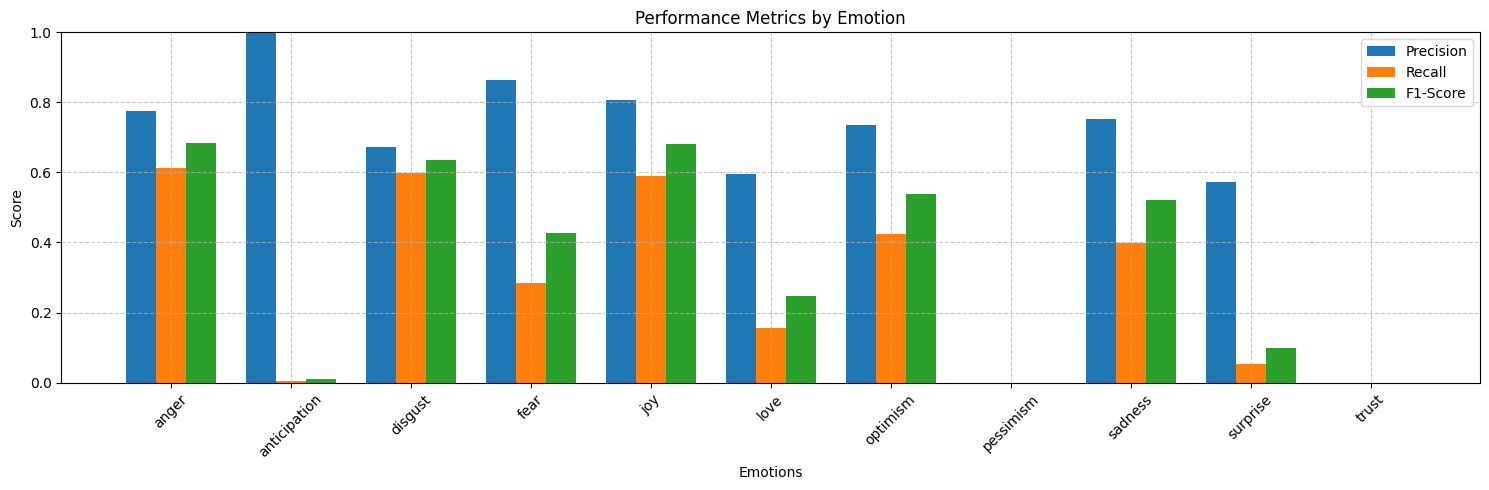

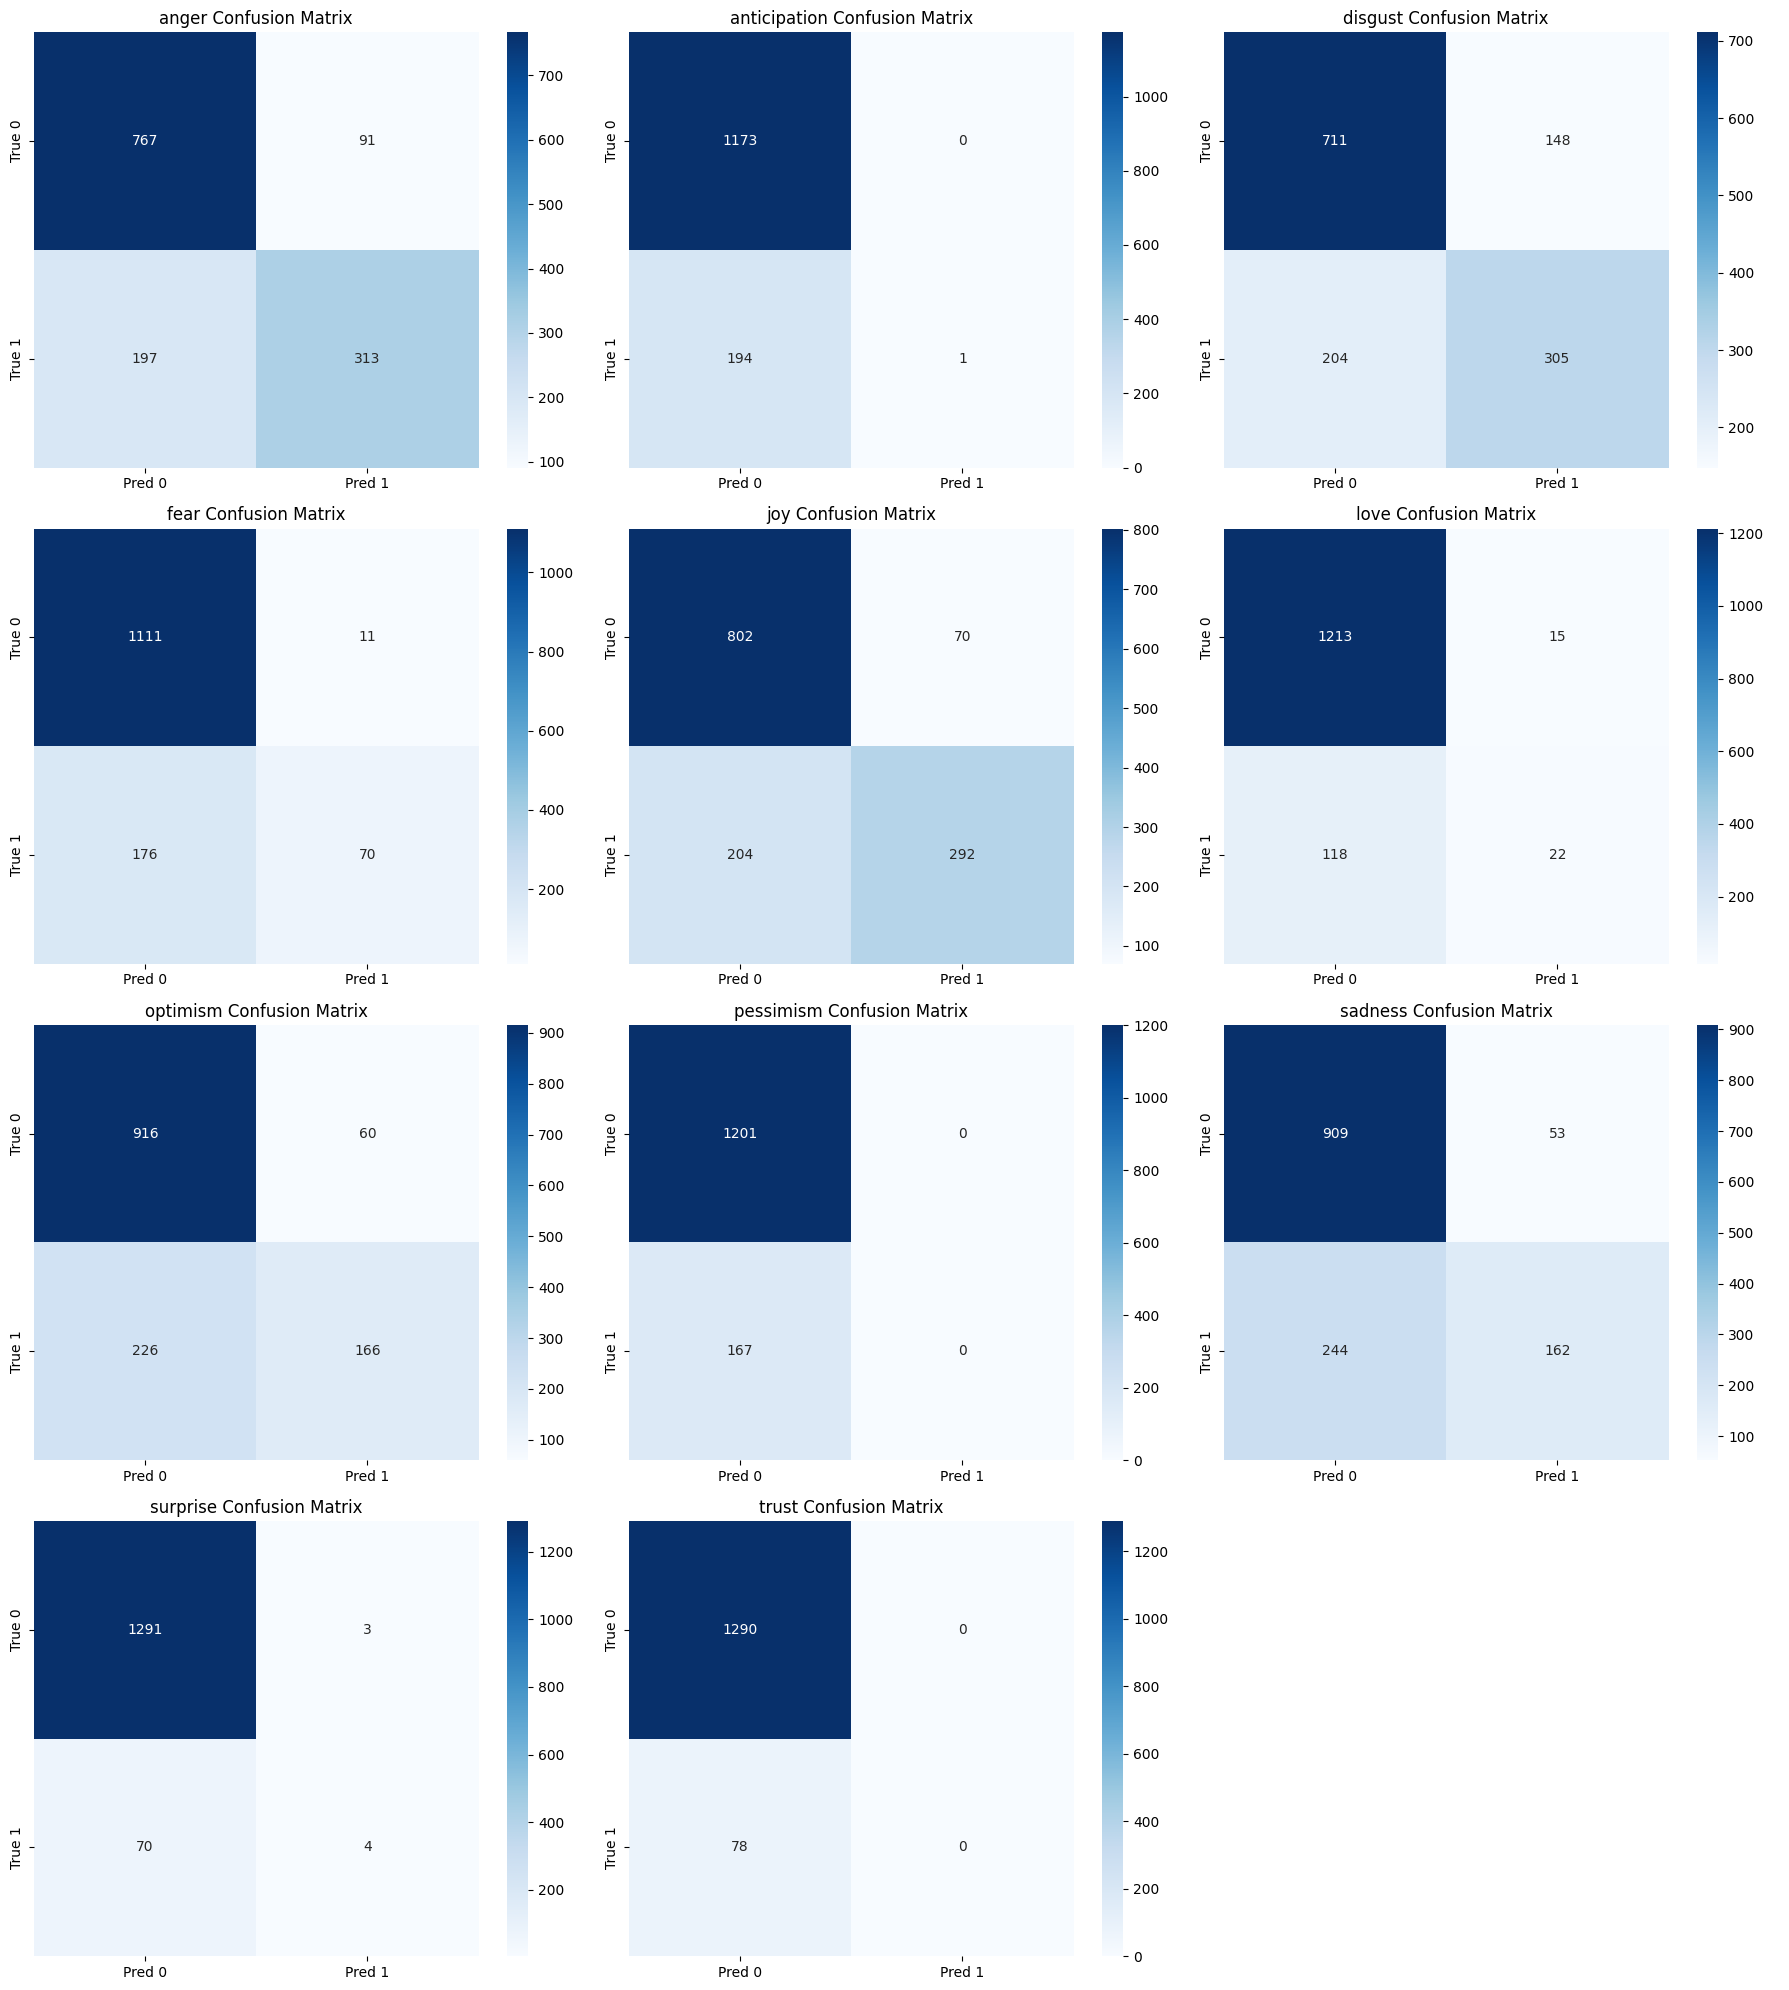



SAMPLE PREDICTIONS:

Tweet: look what we have available in store now n nliquid incense for those who can t burn sticks or cones or have smoke in they home
True Labels: ['joy']
Predicted Labels: ['anger', 'disgust']
---

Tweet: and naoto nod she also like tha bands but she also frown will the bands papa roach be at concert
True Labels: ['anticipation']
Predicted Labels: []
---

Tweet: ill say it again if i was a black man id be afraid to leave my house or have a moving violation n nterrancecrutcher truth sad
True Labels: ['sadness']
Predicted Labels: ['disgust', 'sadness']
---

Tweet: hrc has the experience temperment knowledge amp ability to lead us in this perilous time
True Labels: ['joy', 'optimism', 'trust']
Predicted Labels: []
---

Tweet: hahaha rhe is a bully though rlike really a bully ronly sugita tamed the bully in him
True Labels: ['anger', 'disgust', 'joy']
Predicted Labels: ['anger', 'disgust', 'joy']
---


In [9]:
# generate predictions
y_pred_test = final_preds

Y_test_values = Y_test.values if isinstance(Y_test, pd.DataFrame) else Y_test

# evaluation metrics
print("\nClassification Report (Test):")
print(classification_report(Y_test_values, y_pred_test, target_names=emotions, zero_division=0))

# calculate micro and macro F1 scores
print("\nMicro F1:", f1_score(Y_test_values, y_pred_test, average='micro'))
print("Macro F1:", f1_score(Y_test_values, y_pred_test, average='macro'))

# plotting functions
def plot_metrics(Y_true, Y_pred):
    metrics = {
        'Precision': precision_score(Y_true, Y_pred, average=None),
        'Recall': recall_score(Y_true, Y_pred, average=None),
        'F1-Score': f1_score(Y_true, Y_pred, average=None)
    }

    plt.figure(figsize=(15, 5))
    x = np.arange(len(emotions))
    width = 0.25

    for i, (metric_name, values) in enumerate(metrics.items()):
        plt.bar(x + i * width, values, width, label=metric_name)

    plt.xlabel('Emotions')
    plt.ylabel('Score')
    plt.title('Performance Metrics by Emotion')
    plt.xticks(x + width, emotions, rotation=45)
    plt.ylim(0, 1)  # Ensure y-axis goes to 1.0
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrices(Y_true, Y_pred):
    fig, axes = plt.subplots(4, 3, figsize=(18, 20))
    axes = axes.ravel()

    for i, emotion in enumerate(emotions):
        cm = multilabel_confusion_matrix(Y_true[:, i], Y_pred[:, i])[1]
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                   xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
        axes[i].set_title(f'{emotion} Confusion Matrix')

    for j in range(len(emotions), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

def show_sample_predictions(X_test, Y_test_values, pred_labels, num_samples=5):
    sample_idx = np.random.choice(len(X_test), num_samples, replace=False)
    for idx in sample_idx:
        print(f"\nTweet: {X_test.iloc[idx]}")
        print("True Labels:", [emotions[i] for i, val in enumerate(Y_test_values[idx]) if val == 1])
        print("Predicted Labels:", [emotions[i] for i, val in enumerate(pred_labels[idx]) if val == 1])
        print("---")

# evaluations
print("\n\nEVALUATION METRICS:")
plot_metrics(Y_test_values, y_pred_test)
plot_confusion_matrices(Y_test_values, y_pred_test)

print("\n\nSAMPLE PREDICTIONS:")
show_sample_predictions(X_test, Y_test_values, y_pred_test)

Epoch 0, Loss: 0.2717
Epoch 100, Loss: 0.1424
Epoch 200, Loss: 0.1360
Epoch 300, Loss: 0.1348
Epoch 400, Loss: 0.1343
Epoch 500, Loss: 0.1340
Epoch 600, Loss: 0.1337
Epoch 700, Loss: 0.1335
Epoch 800, Loss: 0.1332
Epoch 900, Loss: 0.1330
Epoch 999, Loss: 0.1328

Classification Report (Test):
              precision    recall  f1-score   support

       anger       0.55      0.87      0.67       510
anticipation       0.17      0.89      0.29       195
     disgust       0.63      0.64      0.64       509
        fear       0.59      0.56      0.57       246
         joy       0.58      0.82      0.68       496
        love       0.33      0.63      0.44       140
    optimism       0.56      0.60      0.58       392
   pessimism       0.15      0.81      0.25       167
     sadness       0.49      0.61      0.54       406
    surprise       0.06      0.99      0.11        74
       trust       0.06      0.91      0.11        78

   micro avg       0.30      0.73      0.42      3213
   

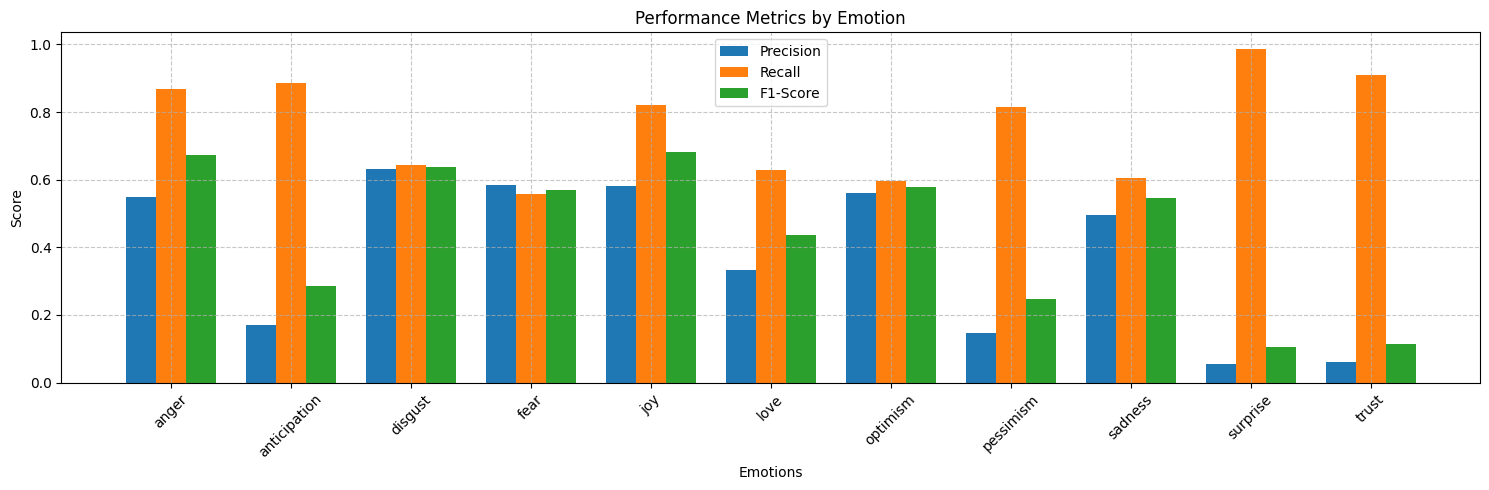

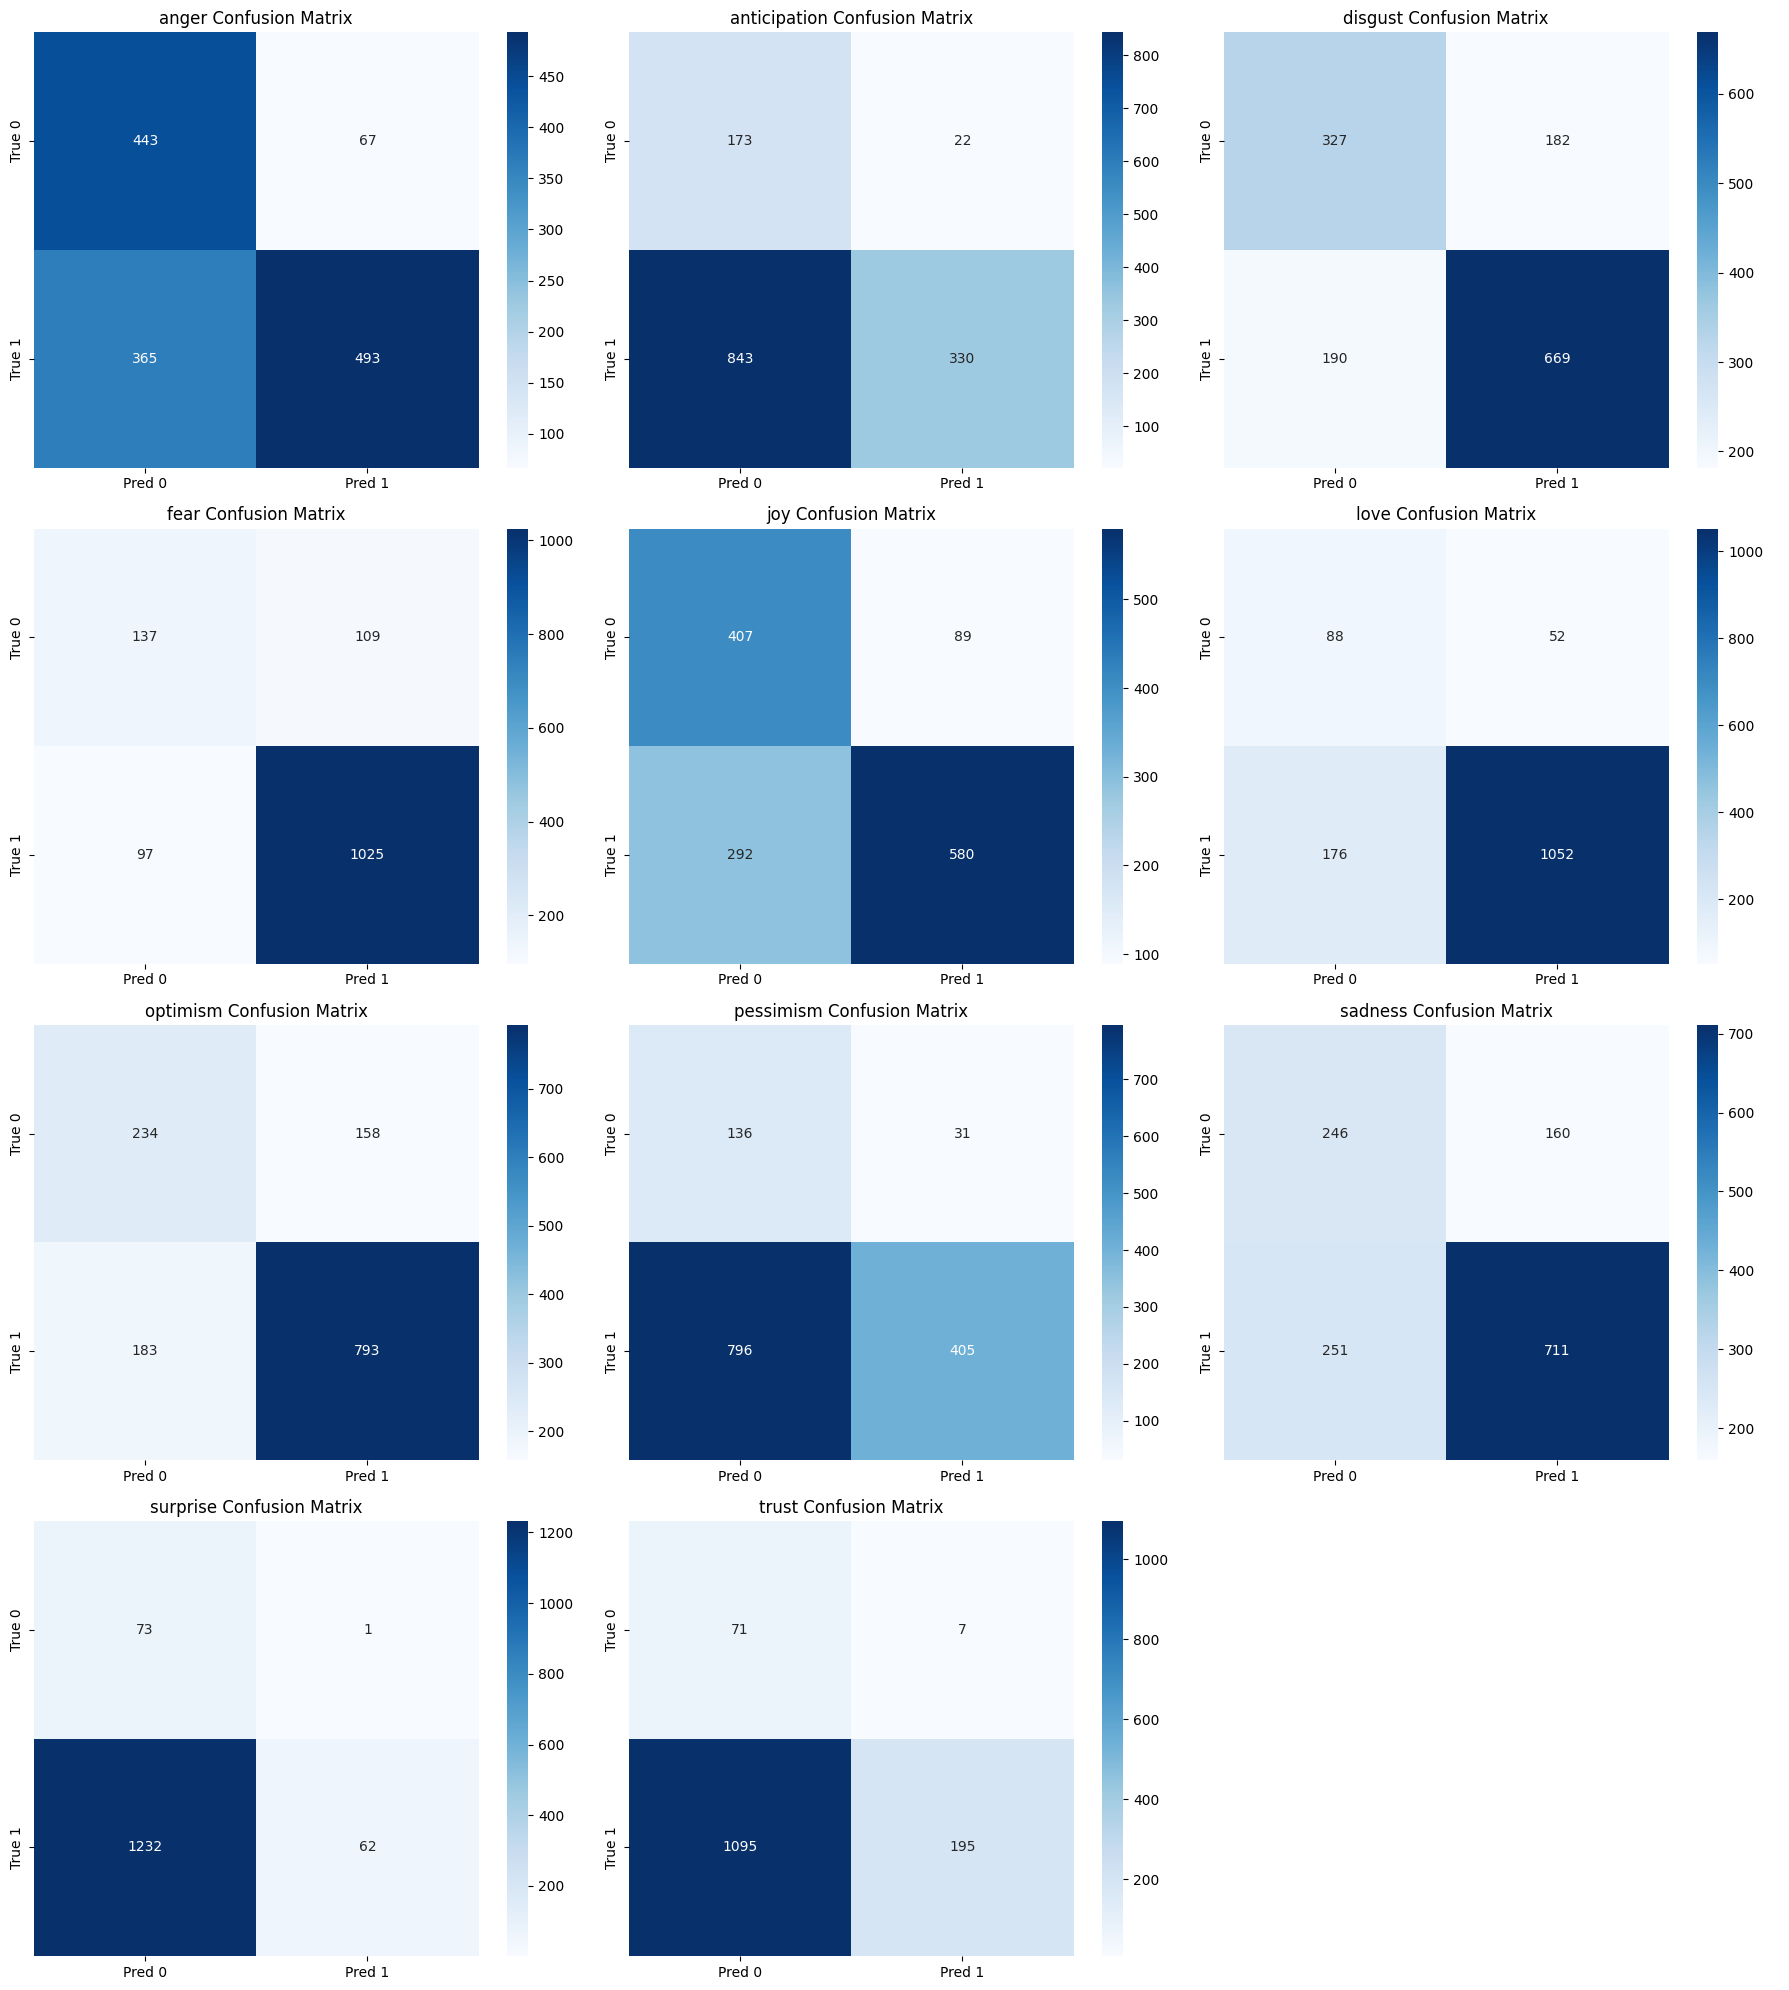



SAMPLE PREDICTIONS:

Tweet: i tried to turn off my alarm this morning and it turned on all my alarms instead
True Labels: ['anger']
Predicted Labels: ['anger', 'joy', 'pessimism', 'sadness', 'surprise']
---

Tweet: congrats to nicole bb fix that nose now bitter petty
True Labels: ['disgust']
Predicted Labels: ['anger', 'anticipation', 'disgust', 'joy', 'pessimism', 'surprise', 'trust']
---

Tweet: while she was in her dull and sleeping hour na crew of patches rude mechanicals namndbots
True Labels: ['pessimism']
Predicted Labels: ['anticipation', 'pessimism', 'surprise', 'trust']
---

Tweet: it s a good day at work when you get to shake jim lehrer s hand thanks still kicking myself for being to shy to hug
True Labels: ['joy', 'love']
Predicted Labels: ['anticipation', 'joy', 'optimism', 'pessimism', 'sadness', 'trust']
---

Tweet: and peter your radio piece on off the ball was pure class no digs no revenge a total balanced pro
True Labels: ['joy', 'optimism', 'surprise', 'trust']
Pre

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    classification_report, f1_score, precision_score, recall_score, multilabel_confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

# helper functions
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def binary_cross_entropy(y_true, y_pred, class_weights=None):
    epsilon = 1e-9
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    loss_per_class = - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    if class_weights is not None:
        loss_per_class *= class_weights
    return np.mean(loss_per_class)

def train_logistic_regression(X, Y, lr=0.01, epochs=1000, class_weights=None):
    n_samples, n_features = X.shape
    n_classes = Y.shape[1]
    weights = np.zeros((n_features, n_classes))
    bias = np.zeros((1, n_classes))

    for epoch in range(epochs):
        linear_output = np.dot(X, weights) + bias
        y_pred = sigmoid(linear_output)
        loss = binary_cross_entropy(Y, y_pred, class_weights)

        dw = np.dot(X.T, (y_pred - Y)) / n_samples
        db = np.sum(y_pred - Y, axis=0, keepdims=True) / n_samples

        weights -= lr * dw
        bias -= lr * db

        if epoch % 100 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch}, Loss: {loss:.4f}")

    return weights, bias

def compute_class_weights(Y):
    class_totals = np.sum(Y, axis=0)
    class_weights = np.where(class_totals != 0, 1.0 / class_totals, 0.0)
    return class_weights / np.max(class_weights)

def find_best_thresholds(y_true, y_probs, steps=100):
    thresholds = np.linspace(0.05, 0.95, steps)
    best_thresholds = []
    for class_idx in range(y_true.shape[1]):
        best_f1 = 0
        best_t = 0.5
        for t in thresholds:
            preds = (y_probs[:, class_idx] >= t).astype(int)
            f1 = f1_score(y_true[:, class_idx], preds, zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_t = t
        best_thresholds.append(best_t)
    return np.array(best_thresholds)

# TF-IDF and model training

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = vectorizer.transform(X_test).toarray()

class_weights = compute_class_weights(Y_train_values)
weights, bias = train_logistic_regression(
    X_train_tfidf, Y_train_values, lr=0.1, epochs=1000, class_weights=class_weights
)

# prediction

y_test_probs = sigmoid(np.dot(X_test_tfidf, weights) + bias)
optimal_thresholds = find_best_thresholds(Y_test_values, y_test_probs)
y_pred_test = (y_test_probs >= optimal_thresholds).astype(int)

# evaluation

print("\nClassification Report (Test):")
print(classification_report(Y_test_values, y_pred_test, target_names=emotions, zero_division=0))

print("\nOptimal Thresholds Per Emotion:")
for emotion, threshold in zip(emotions, optimal_thresholds):
    print(f"{emotion}: {threshold:.2f}")

print("\nMicro F1:", f1_score(Y_test_values, y_pred_test, average='micro'))
print("Macro F1:", f1_score(Y_test_values, y_pred_test, average='macro'))

# plotting functions

def plot_metrics(Y_test_values, pred_labels):
    metrics = {
        'Precision': precision_score(Y_test_values, pred_labels, average=None),
        'Recall': recall_score(Y_test_values, pred_labels, average=None),
        'F1-Score': f1_score(Y_test_values, pred_labels, average=None)
    }

    plt.figure(figsize=(15, 5))
    x = np.arange(len(emotions))
    width = 0.25

    for i, (metric_name, values) in enumerate(metrics.items()):
        plt.bar(x + i * width, values, width, label=metric_name)

    plt.xlabel('Emotions')
    plt.ylabel('Score')
    plt.title('Performance Metrics by Emotion')
    plt.xticks(x + width, emotions, rotation=45)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrices(Y_test_values, pred_labels):
    fig, axes = plt.subplots(4, 3, figsize=(18, 20))
    axes = axes.ravel()

    for i, emotion in enumerate(emotions):
        cm = multilabel_confusion_matrix(Y_test_values[:, i], pred_labels[:, i])[0]
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                    xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
        axes[i].set_title(f'{emotion} Confusion Matrix')

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

def show_sample_predictions(X_test, Y_test_values, pred_labels, num_samples=5):
    sample_idx = np.random.choice(len(X_test), num_samples, replace=False)
    for idx in sample_idx:
        print(f"\nTweet: {X_test.iloc[idx]}")
        print("True Labels:", [emotions[i] for i, val in enumerate(Y_test_values[idx]) if val == 1])
        print("Predicted Labels:", [emotions[i] for i, val in enumerate(pred_labels[idx]) if val == 1])
        print("---")

# evaluation & plots

print("\n\nEVALUATION METRICS:")
plot_metrics(Y_test_values, y_pred_test)
plot_confusion_matrices(Y_test_values, y_pred_test)

print("\n\nSAMPLE PREDICTIONS:")
show_sample_predictions(X_test, Y_test_values, y_pred_test)
